
### Source code for this blog post 
[Here](https://github.com/Xianzhiwang1/CS0451-page-site/tree/main/posts/) is a link to the source code for this Penguin Classification blog post.
### Reference for this blog post
[Here](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-penguins.html) is a link to the main reference we are using when creating this blog post.
# Introduction.
In this blog post I am going to use standard libraries to classify Palmer Penguins using supervised learning. 

Our goal is to classify three types of penguins, `Adelie`, `Chinstrap`, and `Gentoo`. Let's begin!

In [1]:
%load_ext autoreload
%autoreload 2

First, let's import some libraries, and let us load in the data using the function `read_csv`. 

We also need to import the class `PG` from our `penguins.py` source file.

In [72]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)
import numpy as np
np.random.seed(42)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
np.seterr(all="ignore")
import pandas as pd

In [3]:
train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [4]:
from penguins import PG 
PG = PG(train["Species"])

Let us use the `prepare_data` function to generate our training data, and this function is simply a collection of several lines of code that we would like to run first after read in the raw data, and the most convenient way is to put those steps into a function.  

In [5]:
X_train, y_train = PG.prepare_data(train)  

Let's take a peak at what are the columns we have, and we could also print out the first two rows of the data frame while we are at it, so we could see which variable is quantitative, and which variable is coded in binary True and False. After getting this basic information, we turn to some preliminary data exploration using functions such as `groupby` and make some visualizations of the data. First, we make an educated guess that the Flipper length might be closely related to penguin species, and body mass could also help identify species, since some species looks bigger on pictures. Hence, let's get a visualization in there and generate some summary statistics. 

In [6]:
print(X_train.columns)
X_train.head(2)

Index(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
       'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)',
       'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
       'Stage_Adult, 1 Egg Stage', 'Clutch Completion_No',
       'Clutch Completion_Yes', 'Sex_FEMALE', 'Sex_MALE'],
      dtype='object')


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,True,False,False,True,False,True,True,False
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,False,False,True,True,False,True,False,True


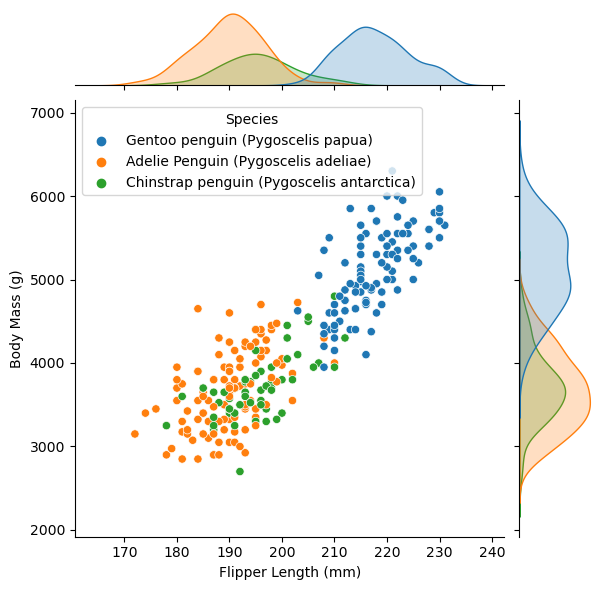

In [7]:
sns.jointplot(data=train, x="Flipper Length (mm)", y="Body Mass (g)", hue="Species")

We see that Gentoo penguin tend to have the biggest body mass and longest flipper length among the three species, and Adelie and Chinstrap panguins are quite mixed together in the dimension of body mass and flipper length. Hence, those two variables are at least very effective at telling Gentoo penguin apart from the others. 

Let us make another plot, and this time, we want to look at Culmen Length and Culmen depth, to see if we could tell the three species apart roughly by these numbers.

<AxesSubplot:xlabel='Culmen Length (mm)', ylabel='Culmen Depth (mm)'>

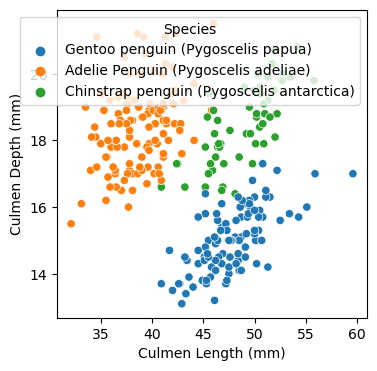

In [8]:
sns.scatterplot(data=train, x="Culmen Length (mm)", y="Culmen Depth (mm)", hue="Species")

We see that the three clusters are quite separated from each other, and this indicates Culmen Length and Culmen Depth are pretty good indicators at telling apart the species. For example, Adelie Penguin tend to have deeper Culmen and shorter Culmen Length, while Gentoo have less deep Culmen and longer Culmen Length. Chinstrap has something in the middle. 

Now, let's generate some summary statistics using `groupby` function.

In [9]:
train.groupby(['Species'])[["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]].aggregate([np.mean, np.max, len]).round(3)

Culmen Length (mm)              
                                                        mean  amax  len   
Species                                                                   
Adelie Penguin (Pygoscelis adeliae)                   38.710  46.0  118  \
Chinstrap penguin (Pygoscelis antarctica)             48.720  55.8   56   
Gentoo penguin (Pygoscelis papua)                     47.757  59.6  101   

                                          Culmen Depth (mm)              
                                                       mean  amax  len   
Species                                                                  
Adelie Penguin (Pygoscelis adeliae)                  18.366  21.5  118  \
Chinstrap penguin (Pygoscelis antarctica)            18.443  20.8   56   
Gentoo penguin (Pygoscelis papua)                    15.035  17.3  101   

                                          Flipper Length (mm)               
                                                         mean   amax  len   
Species                                                                     
Adelie Penguin (Pygoscelis adeliae)                   189.966  210.0  118  \
Chinstrap penguin (Pygoscelis antarctica)             195.464  212.0   56   
Gentoo penguin (Pygoscelis papua)                     217.650  231.0  101   

                                          Body Mass (g)               
                                                   mean    amax  len  
Species                                                               
Adelie Penguin (Pygoscelis adeliae)            3667.094  4725.0  118  
Chinstrap penguin (Pygoscelis antarctica)      3717.857  4800.0   56  
Gentoo penguin (Pygoscelis papua)              5119.500  6300.0  101

It seems that Adelie Penguin have the shortest average Culmen Length, and Chinstrap penguin have the longest average Culmen Length. On the other hand, Adelie and Chinstrap have roughly the same average Culmen depth, while Gentoo have a shorter average Culmen Depth. As of flipper length, Gentoo penguin have the longest average flipper length, while Adelie penguin have the shortest average flipper length. We see that Gentoo penguin has the heaviest average body mass, while Adelie penguin have the lightest average body mass among the three.

Next, we are interested in whether certain species tend to cluster on certain islands, so let us find out using `groupby` function.

In [10]:
train.groupby(["Species", "Island"])["Region"].aggregate([len]).round(3)

len
Species                                   Island        
Adelie Penguin (Pygoscelis adeliae)       Biscoe      35
                                          Dream       41
                                          Torgersen   42
Chinstrap penguin (Pygoscelis antarctica) Dream       56
Gentoo penguin (Pygoscelis papua)         Biscoe     101

We see that all Gentoo penguin are living on Biscoe island, and all Chinstrap penguin are living on Dream island, while Adelie penguin lives on all three islands. Hence, if we choose features by hand, we definitely want to include island as one of the features. 

# Choosing Features

In [11]:
all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 
                  'Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
                  'Stage_Adult, 1 Egg Stage', 'Clutch Completion_No',
                  'Clutch Completion_Yes', 'Sex_FEMALE', 'Sex_MALE']

What we do here is that we choose the feature combination based on which combination have the highest score using Logistic Regression from `sklearn`. We try every single combination exhaustively and compute it's score, and record the combination and score pair in a dictionary. Then we print out the combination with the highest score for future use.

In [12]:
PG.select_combin_Logistic(df=X_train, y=y_train, all_qual_cols=all_qual_cols, all_quant_cols=all_quant_cols)

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [13]:
print(max([-10, 5, 3], key=abs))
print(f"The combination of columns that achieves the highest scores is: {max(PG.feature_score_pair, key = PG.feature_score_pair.get)}")
print(max(PG.feature_score_pair.values()))

-10
The combination of columns that achieves the highest scores is: ('Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)')
1.0


In [14]:

cols = ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 
        'Culmen Length (mm)', 'Culmen Depth (mm)']
print(f"the best column combination where one column is qualitative and two columns are quantitative is:\n{cols}")

the best column combination where one column is qualitative and two columns are quantitative is:
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']


# Model Choices
Let's read in our test data and use the same `prepare_data()` function we have to make our data ready for use.

In [15]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
X_test, y_test = PG.prepare_data(test)

Despite we already have picked a highest scoring combination according to Logistic Regression from `sklearn`, We still want to experiment with different column combinations just to see how things goes with different classifiers. Hence, we keep some combinations that we tried here, and one could commend out other combinations to run the code with the column combination `cols` that they want to try.

In [32]:
cols = ["Flipper Length (mm)", "Body Mass (g)", "Clutch Completion_No", "Clutch Completion_Yes"]
cols = ['Flipper Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)'] 
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)']


cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Body Mass (g)', 
        'Sex_FEMALE', 'Sex_MALE']

cols = ['Island_Biscoe', 'Island_Dream', 'Island_Torgersen',
        'Culmen Length (mm)', 'Culmen Depth (mm)'] 

# Using Support Vector Classification from `scikit-learn`
Here, we are using out-of-the-box implementations from `scikit-learn`, so we just do a very standard work flow with fitting, scoring using cross-validation on testing data, and plotting using a function that's provided from the reference we linked at the start of the post. Let's try the combination of Culmen Length, Dulmen Depth, and Clutch Completion for this one. Then we will stick with the highest scoring combination.

In [33]:
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 
        'Clutch Completion_No', 'Clutch Completion_Yes'] 

In [34]:
mySvc = SVC(kernel="linear", gamma="auto", shrinking=False)

In [35]:
mySvc.fit(X_train[cols],y_train)

SVC(gamma='auto', kernel='linear', shrinking=False)

In [36]:
cross_v_score = cross_val_score(mySvc, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 

the cross validation scores are: [0.91666667 1.         1.         0.90909091 1.         0.72727273]


Scores are really high! And the picture below looks good! It seems the classifier has succesfully classified the penguins! The blue dots are classified as blue, green dots classified in the green region, and so on.

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']


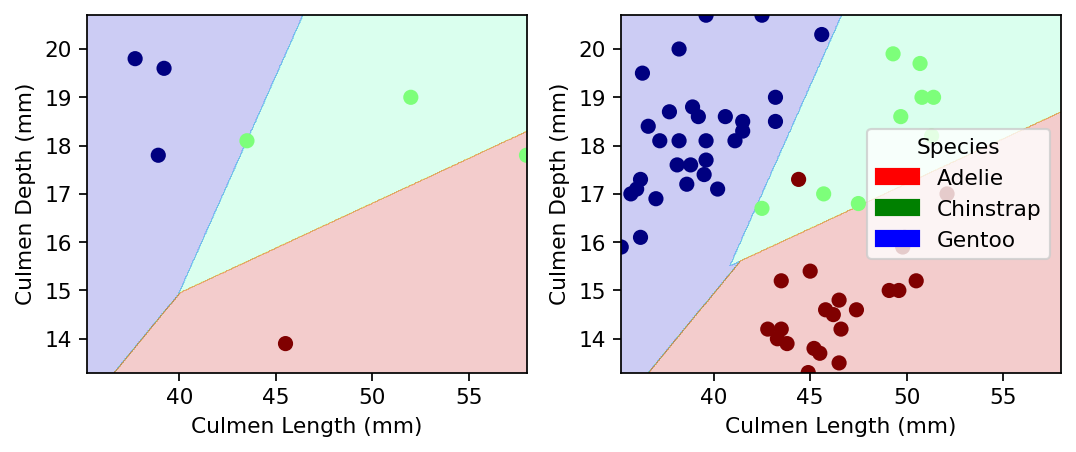

In [37]:
# plt.rcParams["figure.figsize"] = (4,4)
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(mySvc, X_test[cols], y_test)
# PG.plot_regions(mySvc, X_train[cols], y_train)

# Using Random Forest Classifier from `scikit-learn`
Again, we are going to fit, score using cross-validation, and plot a nice graph.

In [69]:
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)',
        'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
rf = RandomForestClassifier(random_state=0)
rf = rf.fit(X_train[cols],y_train)
rf.score(X_train[cols],y_train)

1.0

In [70]:
cross_v_score = cross_val_score(rf, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 

the cross validation scores are: [0.91666667 1.         1.         1.         0.90909091 0.90909091]


Scores are high, but the plot below looks not bad! Our classifier is doing a great job at tellling apart the penguins! It seems all penguins are classified correctly! 

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']


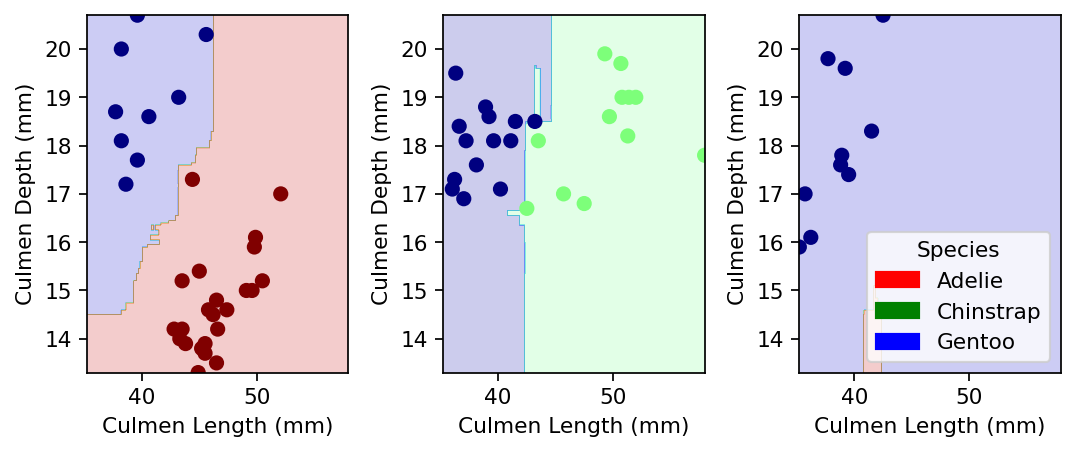

In [71]:
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(rf, X_test[cols], y_test)
# PG.plot_regions(rf, X_train[cols], y_train)

the cross validation scores are: [0.83333333 1.         1.         1.         0.90909091 0.72727273]
['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']


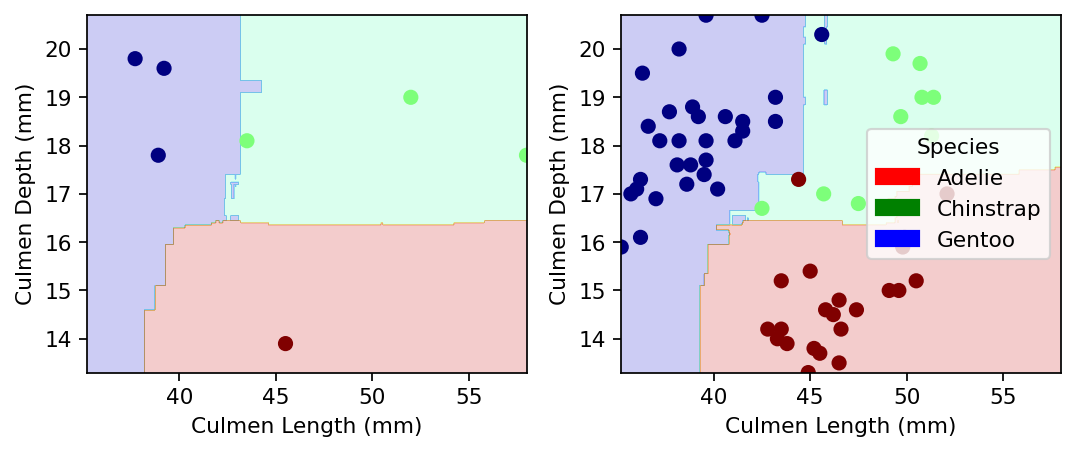

In [56]:

cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 
        'Clutch Completion_No', 'Clutch Completion_Yes'] 
rf = RandomForestClassifier(random_state=0)
rf = rf.fit(X_train[cols],y_train)
rf.score(X_train[cols],y_train)
cross_v_score = cross_val_score(rf, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(rf, X_test[cols], y_test)
# PG.plot_regions(rf, X_train[cols], y_train)

But this time, everything looks good!

# Using Decision Tree from `scikit-learn`
Again, we fit, score, and plot.

In [65]:
cols = ['Culmen Length (mm)', 'Culmen Depth (mm)',
        'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train[cols], y_train)
clf.score(X_train[cols], y_train)

1.0

In [66]:
print(f"The clf.score() on testing data is: {clf.score(X_test[cols], y_test)}")

The clf.score() on testing data is: 0.9852941176470589


In [67]:
cross_v_score = cross_val_score(clf, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 

the cross validation scores are: [0.91666667 0.91666667 1.         1.         0.90909091 0.90909091]


We have pretty high scores, but the plot looks slightly weird with the green rectangle region between blue and red that is predicted Chinstrap, but we doing actually have penguins there! Decision Tree is not good at classifying the penguins using these columns!

['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']


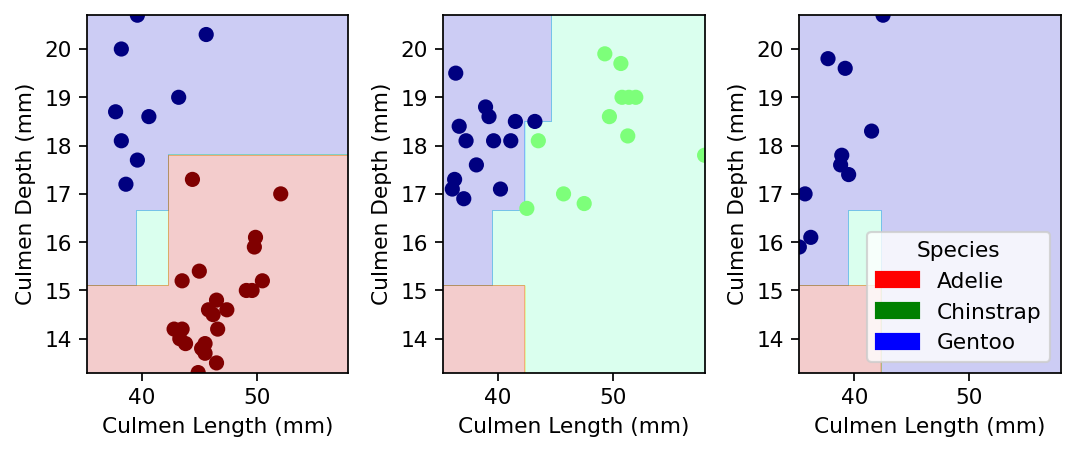

In [68]:
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(clf, X_test[cols], y_test)
# PG.plot_regions(clf, X_train[cols], y_train)

The clf.score() on testing data is: 0.9411764705882353
the cross validation scores are: [0.83333333 0.91666667 1.         0.72727273 0.90909091 0.72727273]
['Culmen Length (mm)', 'Culmen Depth (mm)', 'Clutch Completion_No', 'Clutch Completion_Yes']


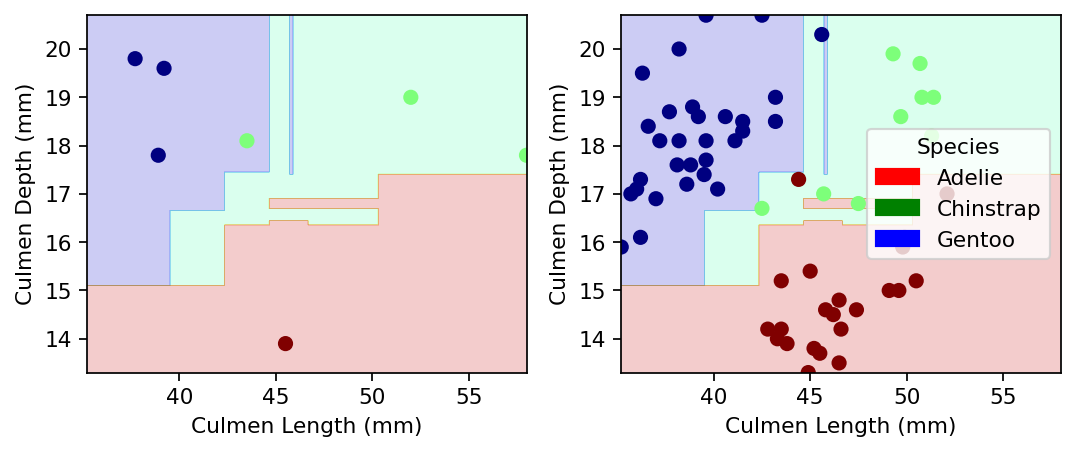

In [61]:

cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 
        'Clutch Completion_No', 'Clutch Completion_Yes'] 
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train[cols], y_train)
clf.score(X_train[cols], y_train)
print(f"The clf.score() on testing data is: {clf.score(X_test[cols], y_test)}")
cross_v_score = cross_val_score(clf, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(clf, X_test[cols], y_test)
# PG.plot_regions(clf, X_train[cols], y_train)

This looks more like it! With this column conbination, our classifier is doing great at telling apart the penguins!

# Bonus: personally hand-picked columns with Logistic Regression from `sklearn`
After performing the exploration during the first half of this blog post, we could develop a rough idea about which variables could "contribute more" to the model for the goal of classification. Hence, based on previous analysis, I think the Culmen Depth of penguins, measured in mm, is quite central to guessing which species is the penguin under question.

Also, we have seen that different species of penguins also tend to have different Body Mass. Island that the penguin lives on is also another telling factor.

In [28]:
# Hand picked columns based on the exploration we did before
cols = ['Culmen Depth (mm)', 'Body Mass (g)',
        'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_test[cols], y_test) 

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7941176470588235

In [29]:
print(f"The LR.score() on testing data is: {LR.score(X_test[cols], y_test)}")

The LR.score() on testing data is: 0.7941176470588235


In [30]:
cross_v_score = cross_val_score(LR, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 

the cross validation scores are: [0.83333333 0.83333333 0.81818182 0.81818182 0.72727273 0.81818182]


The cross validation scores are not super high compared to other models we have seen in this blog, but the picture below looks good! The model did a especially good job at telling apart Adelie and Gentoo, and a less-good job at telling apart Gentoo and Chinstrap.

['Culmen Depth (mm)', 'Body Mass (g)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']


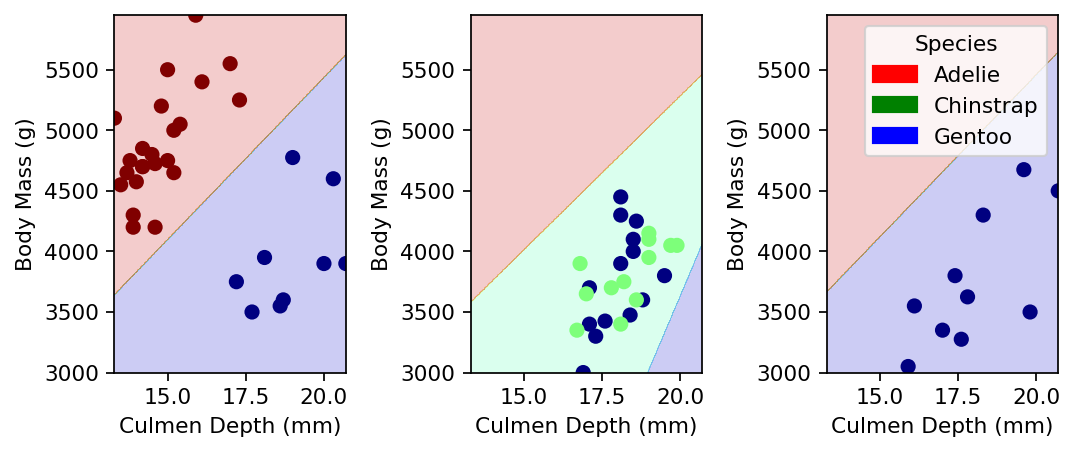

In [31]:
# plt.rcParams["figure.figsize"] = (4,4)
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(LR, X_test[cols], y_test)
# PG.plot_regions(LR, X_train[cols], y_train)

Since we selected this highest scoring combination using logistic regression, we might as well to see how it performs exactly!

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

the cross validation scores are: [1.         1.         1.         1.         0.90909091 0.90909091]
['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']


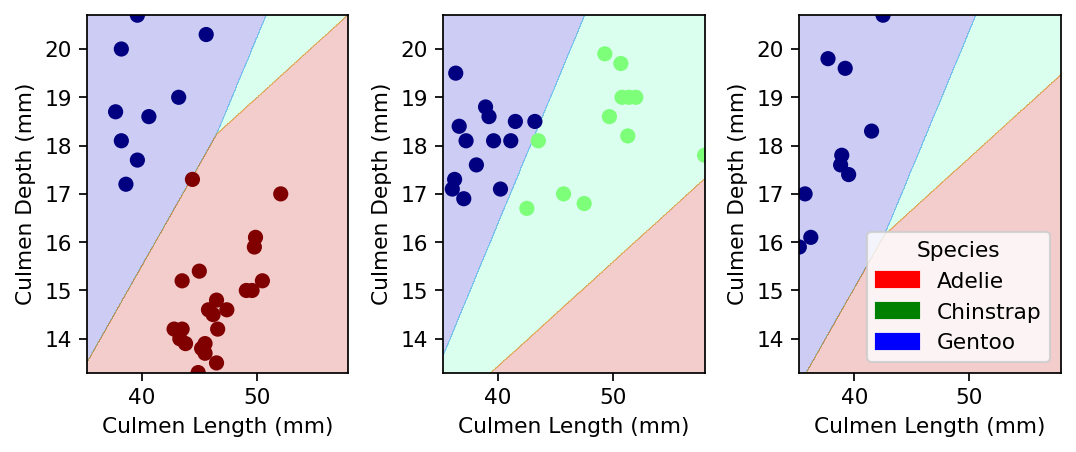

In [64]:

cols = ['Culmen Length (mm)', 'Culmen Depth (mm)',
        'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_test[cols], y_test) 
cross_v_score = cross_val_score(LR, X_test[cols], y_test, cv = 6)
print(f"the cross validation scores are: {cross_v_score}") 
print(cols)
plt.rcParams['figure.dpi'] = 156
PG.plot_regions(LR, X_test[cols], y_test)